motivation: tpus are suspended all the time, so curves are segmented

In [5]:
import json
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

s3b_bs16k = {
    "vlm_clip": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_bs16384_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_12lyr_07-25_1415",
    # "vlm_siglip_v4-32": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/siglip_replication_pod_04-11_2247",
    # "vlm_coca_6lyr": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/coca_replication_s3b_bs16384_warm0.03_1.0co-1.0ca_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_6lyr_scan-F_fsdp-F_08-19_0355",
    "contrastive_9+9_llm_gap_0.01": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.01-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_09-01_0446",
}
s9b_bs32k = {
    "vlm_clip_s9b_bs32k": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_s9b_bs32k_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_08-09_0655",
    "vlm_siglip_s9b_bs32k":"gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/siglip_s9b_bs32k_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_08-04_0839",
    "vlm_cappa_s9b_bs32k":"gs://us-central2-storage/tensorflow_datasets/cappa_bs32768_s9B_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_6lyr_08-07_2217",
    "vlm_coca_6lyr_s9b_bs32k":"gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/coca_unified_s9b_bs32768_warm0.03_1.0co-1.0ca_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_6lyr_scan-F_fsdp-F_08-20_0246",
    "contrastive_unfreeze_llm_half_s9b_bs32k": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-0.1_b16-F_contrastive_bs32768_s9b_wd1e-4_08-21_1935",
}

ablations = {
    # "vlm_clip_gemma_scale": "gs://us-central2-storage/tensorflow_datasets/vit-b-16_3b_pretraining/clip_scale-gemma_s3b_bs16k_warm0.03_lr1e-3_wd1e-4_bf16_qknorm-F_b2-0.95_08-31_2145",
    # "contrastive_freeze_llm": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-T_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-18_0712",
    # "contrastive_unfreeze_llm": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-20_2032",
    # "contrastive_unfreeze_llm_6lyr": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-6lyr-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-20_2032",
    # "contrastive_unfreeze_llm_6lyr_map": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-6lyr-0.1-map_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-27_1857",
    # "contrastive_unfreeze_llm_half": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-21_1935",
    # "contrastive_unfreeze_llm_half_scratch": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-scratch-0.1_so400m-F_contrastive_bs16384_s3b_wd1e-4_08-22_0327",
    # "contrastive_unfreeze_llm_ln_gap": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-ln-0.1-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-28_1538",
    # "contrastive_9+9_llm_map": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.1-map_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-30_1639",
    "contrastive_9+9_llm_gap_0.01_drop0.0_vocab256128": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.01-drop0.0-gap-vocab256128_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_09-03_2131",
    "contrastive_9+9_llm_gap_0.1_drop0.0": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.1-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_08-28_1934",
    "contrastive_9+9_llm_gap_0.01_drop0.2": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.01-drop0.2-gap_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_09-02_1819",
    "contrastive_9+9_llm_eos_0.01_drop0.0": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-partial_frozen99-0.01-drop0.0-eos_b16-F_contrastive_bs16k_s3b_lr1e-3_wd1e-4_bf16_09-03_0033",
    # "generative_unfreeze_llm_half": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-half-pretrained-0.1_so400m-F_generative_bs16384_s3b_wd1e-4_08-22_0402",
    # "generative_unfreeze_llm_full": "gs://us-central2-storage/tensorflow_datasets/mllm_ckpts/paligemma/gemma2b-full-0.1_so400m-F_generative_bs16384_s3b_wd1e-4_08-25_0445",
} 

experiments_dict = {
    **s3b_bs16k,
    **ablations,
    # **s9b_bs32k,
}


def get_metrics(experiment_name, x_axis='examples_seen', y_axis='z/0shot/imagenet2012_accuracy'):
    ckpt_path = experiments_dict[experiment_name]
    metrics_path = f'{ckpt_path}/big_vision_metrics.txt'

    metrics = {}
    # count = 1
    with tf.io.gfile.GFile(metrics_path, 'r') as f:
        lines = f.read().split('\n')
        for line in lines:
            if len(line) == 0:
                continue
            line_dict = json.loads(line)
            if line_dict['step'] % 1000 == 0 or 'z/0shot/imagenet2012_accuracy' in line_dict.keys():
                # if count==1:
                #     print(line_dict.keys())
                #     count = 0
                x = line_dict[x_axis]
                y = line_dict[y_axis] if y_axis in line_dict else None
                if y is not None:
                    metrics[x] = y
    return metrics

Getting metrics for vlm_clip and step vs. z/0shot/imagenet2012_accuracy
Getting metrics for contrastive_9+9_llm_gap_0.01 and step vs. z/0shot/imagenet2012_accuracy
Getting metrics for contrastive_9+9_llm_gap_0.01_drop0.0_vocab256128 and step vs. z/0shot/imagenet2012_accuracy
Getting metrics for contrastive_9+9_llm_gap_0.1_drop0.0 and step vs. z/0shot/imagenet2012_accuracy
Getting metrics for contrastive_9+9_llm_gap_0.01_drop0.2 and step vs. z/0shot/imagenet2012_accuracy
Getting metrics for contrastive_9+9_llm_eos_0.01_drop0.0 and step vs. z/0shot/imagenet2012_accuracy


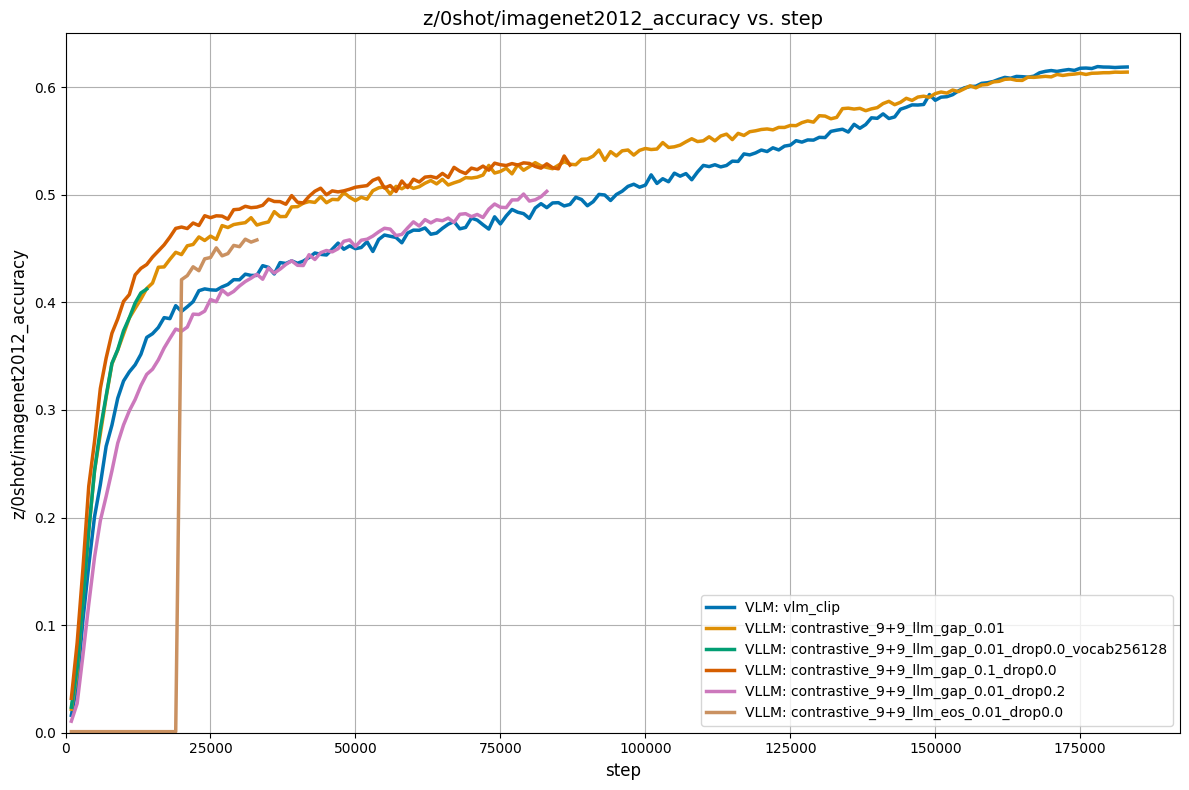

In [6]:
# Collect data for all experiments
x_axis = 'step' 
# step, examples_seen, core_hours, 
# global_schedule, lr, lr_schedule, uptime, progress, epoch, core_hours_TPU v4
y_axis = 'z/0shot/imagenet2012_accuracy'
# y_axis = 'l2_grads'
# l2_grads, l2_params, l2_updates, training_loss,
# z/retr/coco_img2txt_recall@1, z/retr/coco_img2txt_recall@5, z/retr/coco_img2txt_recall@10,
# z/retr/coco_txt2img_recall@1, z/retr/coco_txt2img_recall@5, z/retr/coco_txt2img_recall@10,
# z/0shot/imagenet2012_accuracy, z/0shot/imagenet_v2_accuracy, z/0shot/imagenet2012_real_accuracy
all_metrics = {}
for experiment_name in experiments_dict.keys():
    print(f'Getting metrics for {experiment_name} and {x_axis} vs. {y_axis}')
    all_metrics[experiment_name] = get_metrics(experiment_name, x_axis=x_axis, y_axis=y_axis)


# Plot all experiments on the same graph
plt.figure(figsize=(12, 8))

vlm_experiments = [exp for exp in experiments_dict.keys() if 'vlm' in exp]
llm_experiments = [exp for exp in experiments_dict.keys() if 'llm' in exp]

# Define color schemes for vlm and llm groups
palette = sns.color_palette("colorblind", 8)
vlm_colors = palette[:len(vlm_experiments)]  # First colors for CLIP
llm_colors = palette[len(vlm_experiments):]  # Last colors for LLM

# Plot VLM experiments
for i, experiment_name in enumerate(vlm_experiments):
    metrics = all_metrics[experiment_name]
    linestyle = '-.' if 's9b_bs32k' in experiment_name else '-'
    plt.plot(list(metrics.keys()), list(metrics.values()), label=f'VLM: {experiment_name}', 
             color=vlm_colors[i % len(vlm_colors)], linewidth=2.5, linestyle=linestyle)

# Plot VLLM experiments
for i, experiment_name in enumerate(llm_experiments):
    metrics = all_metrics[experiment_name]
    linestyle = '--' if 's9b_bs32k' in experiment_name else '-'
    plt.plot(list(metrics.keys()), list(metrics.values()), label=f'VLLM: {experiment_name}', 
             color=llm_colors[i % len(llm_colors)], linewidth=2.5, linestyle=linestyle)

plt.xlabel(f'{x_axis}', fontsize=12)
plt.ylabel(f'{y_axis}', fontsize=12)
plt.xlim(0)
plt.ylim(0)
plt.legend(fontsize=10)
plt.title(f'{y_axis} vs. {x_axis}', fontsize=14)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

# # Plot all experiments on the same graph
# plt.figure(figsize=(12, 8))
# for experiment_name, metrics in all_metrics.items():
#     linestyle = '-.' if 's9b_bs32k' in experiment_name else '-'
#     plt.plot(list(metrics.keys()), list(metrics.values()), label=experiment_name, linewidth=2.5, linestyle=linestyle)
# plt.xlabel(f'{x_axis}', fontsize=12)
# plt.ylabel(f'{y_axis}', fontsize=12)
# plt.xlim(0)
# plt.ylim(0)
# plt.legend(fontsize=10)
# plt.title(f'{y_axis} vs. {x_axis}', fontsize=14)
# plt.grid(True)
# plt.tick_params(axis='both', which='major', labelsize=10)
# plt.show()

In [7]:
# Print final metrics for each experiment
for experiment_name, metrics in all_metrics.items():
    final_metric = list(metrics.values())[-1]
    print(f"Final {experiment_name} metric: {final_metric}")

Final vlm_clip metric: 0.61872
Final contrastive_9+9_llm_gap_0.01 metric: 0.61396
Final contrastive_9+9_llm_gap_0.01_drop0.0_vocab256128 metric: 0.41234
Final contrastive_9+9_llm_gap_0.1_drop0.0 metric: 0.52756
Final contrastive_9+9_llm_gap_0.01_drop0.2 metric: 0.50312
Final contrastive_9+9_llm_eos_0.01_drop0.0 metric: 0.45794
